In [1]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [2]:
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt

In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_bert_features.csv") #train data
test_data = pd.read_csv("acp_test_bert_features.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Step 3: Define the XGBoost model and hyperparameter grid
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42) #Random state for reproducibility, logloss for binary classification

param_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000], #Number of boosting rounds:Range: 100-1000, Default: 100
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], #Maximum tree depth:Range: 3-10, Default: 6
    'learning_rate': [0.01, 0.1, 0.2, 0.3], #Step size shrinkage used to prevent ovexgbitting:Range: 0.01-0.3, Default: 0.3
    'subsample': [0.6, 0.8, 1.0], #Fraction of samples used for training trees, Range: 0.5-1.0, Default: 1
    'min_child_weight': [1], #Minimum sum of instance weight (hessian) needed in a child, Range: 1-10, Default: 1
}

# Step 4: Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid, #param_grid is defined above
    scoring='accuracy', #scoring is set to 'accuracy'
    n_jobs= 1, #number of jobs to run in parallel, reasonable value is -1
    cv=5,
    verbose=2 #verbose means how much information to print, 2 means print everything
)
grid_search.fit(X_train, y_train)

# Step 5: Print the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Step 6: Use the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Save best hyperparameters to a file
with open('best_model_info_xgb_protbert.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_xgb_protbert.txt'")

#save best model to a file
joblib.dump(best_xgb_model, "best_xgb_protbert_model.pkl")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.4s
[CV] END learning_rate=0

C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
13 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File 

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}
Best model information has been saved to 'best_model_info_xgb_protbert.txt'


['best_xgb_protbert_model.pkl']

In [5]:
# Step 8: Fit the model on the training data
best_xgb_model.fit(X_train, y_train)

# Evaluate on the test dataset
y_test_pred = best_xgb_model.predict(X_test)
y_test_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate and print accuracy, classification reports, and confusion matrices
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"xgb Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

xgb Test Accuracy: 78.38%
Confusion Matrix (Test Data):
 [[70 21]
 [19 75]]
Test Data - Sensitivity: 0.7978723404255319 Specificity: 0.7692307692307693


In [6]:
print("Confusion Matrix (Test Data):")
print(f"TN: {confusion_matrix_test[0,0]}  FP: {confusion_matrix_test[0,1]}")
print(f"FN: {confusion_matrix_test[1,0]}  TP: {confusion_matrix_test[1,1]}")

Confusion Matrix (Test Data):
TN: 70  FP: 21
FN: 19  TP: 75


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("F1 Score (Test Data):", f1_test)

Precision: 0.78125
Matthews Correlation Coefficient (MCC): 0.5674348847444467
F1 Score (Test Data): 0.7894736842105263


In [8]:
#calculation of classification report for test and evaluation data
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.79      0.77      0.78        91
           1       0.78      0.80      0.79        94

    accuracy                           0.78       185
   macro avg       0.78      0.78      0.78       185
weighted avg       0.78      0.78      0.78       185



In [9]:
# Evaluate on the test dataset
y_test_pred = best_xgb_model.predict(X_test)
y_test_prob = best_xgb_model.predict_proba(X_test)[:, 1]

Test Data ROC AUC: 0.8436988543371522
Test Data FPR: [0.         0.         0.         0.01098901 0.01098901 0.02197802
 0.02197802 0.03296703 0.03296703 0.04395604 0.04395604 0.05494505
 0.05494505 0.07692308 0.07692308 0.08791209 0.08791209 0.10989011
 0.10989011 0.12087912 0.12087912 0.15384615 0.15384615 0.16483516
 0.16483516 0.18681319 0.18681319 0.20879121 0.20879121 0.23076923
 0.23076923 0.24175824 0.24175824 0.25274725 0.25274725 0.26373626
 0.26373626 0.30769231 0.30769231 0.36263736 0.36263736 0.37362637
 0.37362637 0.3956044  0.3956044  0.42857143 0.42857143 0.43956044
 0.43956044 0.48351648 0.48351648 0.53846154 0.53846154 0.68131868
 0.68131868 0.7032967  0.7032967  0.74725275 0.74725275 0.96703297
 0.96703297 1.        ]
Test Data TPR: [0.         0.0106383  0.20212766 0.20212766 0.25531915 0.25531915
 0.31914894 0.31914894 0.32978723 0.32978723 0.42553191 0.42553191
 0.43617021 0.43617021 0.45744681 0.45744681 0.5106383  0.5106383
 0.57446809 0.57446809 0.60638298 0.60

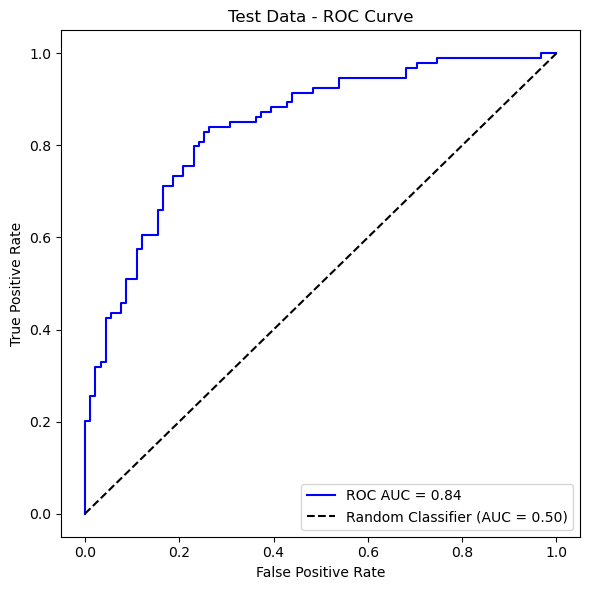

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("xgb_protbert_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'xgb_protbert_roc_auc_curve.png'.")

# Show the plot
plt.show()

In [11]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_xgb_protbert.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_xgb_protbert.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.71621622 0.85135135 0.74324324 0.72972973 0.7972973  0.75675676
 0.89189189 0.78378378 0.76712329 0.79452055]
Mean 10-Fold CV Accuracy: 0.7831914105886708
Accuracy of each fold has been saved to 'cv_accuracies_xgb_protbert.txt'


Mean Accuracy: 78.32
Mean AUC: 1.0000


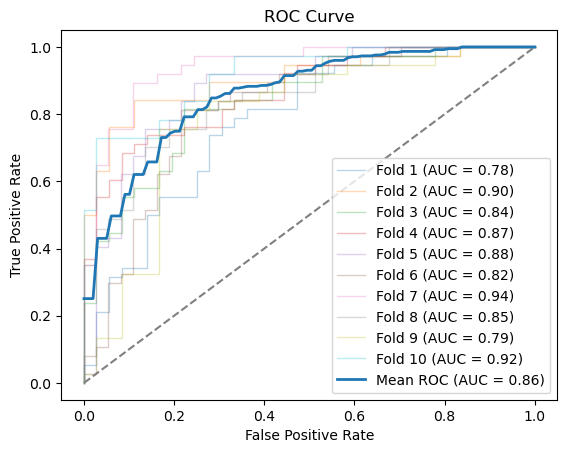

In [12]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_xgb_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_xgb_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_xgb_protbert.png", dpi=500)
plt.show()